**Importing Packages**

In [24]:
import sqlite3
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

**Connecting To Database**

In [25]:
df = pd.read_csv("train_preprocess.tsv.txt" ,encoding="latin1",sep='\t',header=None,names=["text","label"])
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [26]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [27]:
#Cek duplikasi data

df.duplicated().sum()

67

In [28]:
# Hapus duplicated data

df = df.drop_duplicates()

**CLEANSING**

In [29]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
list_stopwords = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
df_alay = pd.read_csv('new_kamusalay.csv', encoding='ISO-8859-1', header=None)
df_alay = df_alay.rename(columns={0: 'alay', 1: 'formal'})

In [31]:
df_alay.head()

,alay,formal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
list_stopwords = set(stopwords.words('indonesian'))

def data_cleaning (text):
    clean1 = re.sub ('\\n','', text)
    clean2 = re.sub ('RT',' ', clean1)
    clean3 = re.sub ('USER', ' ', clean2)
    clean4 = re.sub ('(http|https):\/\/s+', ' ', clean3)
    clean5 = re.sub ('[^0-9a-zA-Z]+', ' ', clean4)
    clean6 = re.sub ('x[a-z0-9]{2}', ' ', clean5)
    clean7 = re.sub ("\d+", ' ', clean6)
    clean8 = re.sub ('  +', '', clean7)
    return clean8

def case_folding (text):
    return text.lower()

def alay_normalization(text):
    res = ''
    for item in text.split():
        if item in df_alay['alay'].values:
            res += df_alay[df_alay['alay'] == item]['formal'].iloc[0]
        else:
            res += item
        res += ' '
    return res

def stopword_removal(text):
    resp = ''
    for item in text.split():
        if item not in list_stopwords:
            resp += item
        resp +=' '
    clean = re.sub('  +', ' ', resp)
    return clean

def cleansing(text):
    text = data_cleaning(text)
    text = case_folding(text)
    text = alay_normalization(text)
    text = stopword_removal(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Apply cleansing
df['text'] = df['text'].apply(cleansing)

In [34]:
df.head()

,text,label
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus kmmbri hujjah partai diwlh s...,neutral
2,lokasi strategis jalan sumatra bandung nya nya...,positive
3,betapa bahagia nya unbo paket barang nya bagus...,positive
4,aduh mahasiswa sombong kasih kartu kuning bela...,negative


**Feature Extraction**

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_preprocessed = df.text.tolist()

In [36]:
# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()

X = tfidf_vect.fit_transform(data_preprocessed)
print("Feature Extraction selesai")

Feature Extraction selesai


In [37]:
pickle.dump(tfidf_vect, open("vectorizer.pkl", "wb"))

In [38]:
tfidf_array = X.toarray()
df_array = pd.DataFrame(data=tfidf_array,columns = tfidf_vect.get_feature_names_out())
print(df_array)

       aakan  aan  aapertizer  aas   ab  abad  abaddengan  abaddigit  abaikan  \
0        0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
1        0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
2        0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
3        0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
4        0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
...      ...  ...         ...  ...  ...   ...         ...        ...      ...   
10928    0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
10929    0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
10930    0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
10931    0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   
10932    0.0  0.0         0.0  0.0  0.0   0.0         0.0        0.0      0.0   

       abal  ...  zonpoliti

### Prepare train and test dataset (split dataset)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
# save output feature in variable classes
classes = df.label

# split dataset to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size = 0.2)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8746, 17046)
(2187, 17046)
(8746,)
(2187,)


## Model Training Neural Network

In [42]:
from sklearn.neural_network import MLPClassifier #load library neural network

In [43]:
# model training menggunakan neural network
model = MLPClassifier()
model.fit(X_train, y_train)

print("Training selesai")

# save model to pickle
pickle.dump(model, open("model_nn.pkl", 'wb'))

Training selesai


## Model Evaluation

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
test = model.predict(X_test)
print ("Testing selesai")
print(classification_report(y_test, test))

Testing selesai
              precision    recall  f1-score   support

    negative       0.73      0.72      0.73       664
     neutral       0.76      0.56      0.65       209
    positive       0.85      0.89      0.87      1314

    accuracy                           0.81      2187
   macro avg       0.78      0.73      0.75      2187
weighted avg       0.81      0.81      0.81      2187



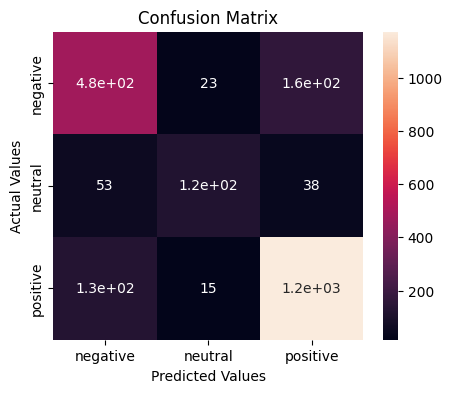

In [46]:
cm = confusion_matrix(y_test, test, labels=["negative", "neutral", "positive"])

cm_df = pd.DataFrame(cm,
                     index =["negative", "neutral", "positive"],
                     columns =["negative", "neutral", "positive"])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Cross Validation

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from statistics import mean, stdev

In [48]:
X = df[["text"]] # input feature
Y = df["label"] # output feature

# split dataset to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [52]:
# cross validation dengan split = 5
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies=[]

X_train = X_train.reset_index().text
y_train = y_train.reset_index().label

In [53]:
def cross_validation(k, X_train, model, name):
  accuracies = []
  precisions = []
  recalls = []
  f1_scores = []

  # iterate sebanyak k cross validation
  for iteration, data in enumerate(kf.split(X_train), start=1):
      # get data and target train
      data_train = X_train[data[0]]
      tfidf_vect = TfidfVectorizer()
      data_train = tfidf_vect.fit_transform(data_train)

      target_train = y_train[data[0]]

      # get data and target test
      data_test =  X_train[data[1]]
      data_test = tfidf_vect.transform(data_test)

      target_test =  y_train[data[1]]

      # model training menggunakan data train
      classifier = model
      classifier.fit(data_train, target_train)

      # prediksi data test
      preds = classifier.predict(data_test)

      # menghitung accuracy
      accuracy = accuracy_score(target_test, preds)
      precision = precision_score(target_test, preds, average='weighted')
      recall = recall_score(target_test, preds, average='weighted')
      f1 = f1_score(target_test, preds, average='weighted')

      # print("Training ke-", iteration)
      # print(classification_report(target_test, preds))
      # print("=================================================================")

      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1)

  result = {'algorithm': name,
                'accuracy_per_iter': accuracies, 'accuracy_mean': mean(accuracies), 'accuracy_std': stdev(accuracies),
                'recall_mean': mean(recalls),'precision_mean': mean(precisions), 'f1_mean': mean(f1_scores)}
  return result

In [54]:
result = cross_validation(5, X_train, MLPClassifier(), "Neural Network")
result

{'algorithm': 'Neural Network',
 'accuracy_per_iter': [0.8022857142857143,
  0.7975986277873071,
  0.7998856489422527,
  0.801600914808462,
  0.8004574042309891],
 'accuracy_mean': 0.8003656620109451,
 'accuracy_std': 0.001810231876546331,
 'recall_mean': 0.8003656620109451,
 'precision_mean': 0.799027847378207,
 'f1_mean': 0.7974978204665732}

**Prediction Test**

In [58]:
original_text =  'SAYA SUKA MAKANAN ITU, ENAK SEKALI'

# Feature Extraction
text = tfidf_vect.transform([cleansing(original_text)])

# Sentiment prediction
result = model.predict(text)[0]
print("Sentiment:", result)

Sentiment: positive


In [60]:
original_text =  'MEREKA bodoh bgt sih.'

# Feature Extraction
text = tfidf_vect.transform([cleansing(original_text)])

# Sentiment prediction
result = model.predict(text)[0]
print("Sentiment:", result)

Sentiment: negative


In [63]:
df_tweet = pd.read_csv("data.csv", encoding='latin-1')

In [64]:
df_predict = df_tweet[['Tweet']].copy()
df_predict.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


In [73]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import joblib

In [74]:
# Memuat vectorizer dan model dari file
vectorizer = joblib.load('vectorizer.pkl')
model_nn = joblib.load('model_nn.pkl')

In [77]:
df_predict['cleaned_tweet'] = df_predict['Tweet'].apply(cleansing)

In [78]:
df_predict.head()

,Tweet,cleaned_tweet
0,- disaat semua cowok berusaha melacak perhatia...,cowok berusaha melacak perhatian gue lantas r...
1,RT USER: USER siapa yang telat ngasih tau elu?...,telat tau edan sarap gue bergaul cigax jifla ...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang berpikir percaya tuhan jatuh berkali ka...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,ku tau matamu sipit
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir dongoknya dungu haha


In [79]:
# Menggunakan vectorizer untuk mengubah teks menjadi vektor fitur
X = vectorizer.transform(df_predict['cleaned_tweet'])

# Melakukan prediksi sentimen dengan model neural network
predictions = model_nn.predict(X)

# Menambahkan kolom sentimen ke dalam DataFrame
df_predict['sentiment'] = predictions

In [86]:
df_predict

,Tweet,cleaned_tweet,sentiment
0,- disaat semua cowok berusaha melacak perhatia...,cowok berusaha melacak perhatian gue lantas r...,negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,telat tau edan sarap gue bergaul cigax jifla ...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang berpikir percaya tuhan jatuh berkali ka...,positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,ku tau matamu sipit,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir dongoknya dungu haha,negative
...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,berbicara ndasmu congor sekateanjyng,negative
13165,USER Kasur mana enak kunyuk',kasur enak kunyuk,negative
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,hati hati bisu bosan duh,negative
13167,USER USER USER USER Bom yang real mudah terdet...,bom real mudah terdeteksi bom terkubur dahsyat...,negative


from matplotlib import pyplot as plt
import seaborn as sns
df_predict.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

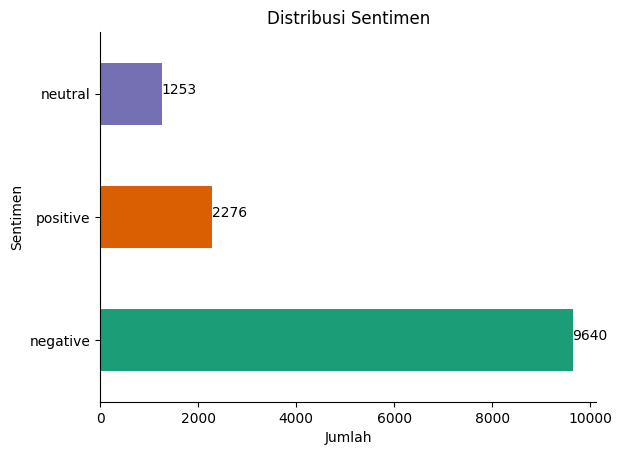

In [88]:
from matplotlib import pyplot as plt
import seaborn as sns

# Menghitung jumlah sentimen
sentiment_counts = df_predict['sentiment'].value_counts()

# Membuat plot diagram batang horizontal
fig, ax = plt.subplots()
sentiment_counts.plot(kind='barh', color=sns.color_palette('Dark2', n_colors=len(sentiment_counts)))

# Menambahkan nilai angka pada batang diagram
for index, value in enumerate(sentiment_counts):
    ax.text(value, index, str(value))

# Menghilangkan garis-garis di atas dan di kanan plot
ax.spines[['top', 'right']].set_visible(False)

# Menyertakan label pada sumbu dan judul
plt.xlabel('Jumlah')
plt.ylabel('Sentimen')
plt.title('Distribusi Sentimen')

# Menampilkan plot
plt.show()

In [83]:
# Menyimpan hasil prediksi ke dalam database SQLite
import sqlite3

conn = sqlite3.connect('sentiment_predictions.db')

# Sesuaikan dengan nama tabel yang sesuai dengan kebutuhan Anda.
df_predict.to_sql('sentiment_predictions', con=conn, index=False, if_exists='replace')

# Tutup koneksi setelah selesai
conn.close()